# Classifiers

In [1]:
# Core Libraries
import os
import glob
import itertools

# Data Handling
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Progress Bar
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Statistics
from scipy.stats import skew, kurtosis, randint

# Modeling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression


In [2]:
df_a =pd.read_parquet('data/tsfresh_whole_a.parquet', engine='pyarrow')
df_c =pd.read_parquet('data/tsfresh_whole_c.parquet', engine='pyarrow')


In [3]:
static_variables = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']

if 'ICUType' not in df_a.columns: static_variables.remove('ICUType')

static_variables_we_want = ['Age', 'Gender', 'Height', 'Weight']
all_variables = ['Weight', 'Age', 'TroponinI', 'DiasABP', 'MechVent', 'HCO3', 'Cholesterol', 'HCT', 'SaO2', 'WBC', 'SysABP', 'Urine', 'ICUType', 'Gender', 'ALP', 'Creatinine', 'K', 'AST', 'Glucose', 'RespRate', 'MAP', 'FiO2', 'BUN', 'Na', 'Bilirubin', 'TroponinT', 'PaCO2', 'Height', 'GCS', 'HR', 'pH', 'PaO2', 'Lactate', 'ALT', 'NISysABP', 'RecordID', 'Platelets', 'Temp', 'Mg', 'NIDiasABP', 'Albumin', 'NIMAP']
dyn_variables = [x for x in all_variables if x not in static_variables]
dyn_variables.append('Weight_VAR')
len(dyn_variables), len(static_variables_we_want)

(38, 4)

In [4]:
assert df_a.isnull().sum().sum() == 0
# assert df_b.isnull().sum().sum() == 0
assert df_c.isnull().sum().sum() == 0

In [5]:
df_a['RecordID_first']

132539.0    132539.0
132540.0    132540.0
132541.0    132541.0
132543.0    132543.0
132545.0    132545.0
              ...   
142665.0    142665.0
142667.0    142667.0
142670.0    142670.0
142671.0    142671.0
142673.0    142673.0
Name: RecordID_first, Length: 4000, dtype: float64

In [6]:
outcomes = pd.read_csv('data/outcomes.csv')

outcomes_a = outcomes.loc[outcomes['RecordID'].isin(df_a['RecordID_first'])]
# outcomes_b = outcomes.loc[outcomes['RecordID'].isin(df_b['RecordID_first'])]
outcomes_c = outcomes.loc[outcomes['RecordID'].isin(df_c['RecordID_first'])]

## Random forest


Random search is surprisingly efficient compared to grid search. Although grid search will find the optimal value of hyperparameters (assuming they are in your grid) eventually, random search will usually find a "close-enough" value in far fewer iterations.

In [7]:
# --- Utility Functions ---
def evaluate_model(model, X, y_true, title_info=None):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix, " + (title_info if title_info else ""))
    plt.show()

    roc_auc = roc_auc_score(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")
    return roc_auc, avg_precision

def train_rf(X_train, y_train, **kwargs):
    rf = RandomForestClassifier(random_state=42, **kwargs)
    rf.fit(X_train, y_train)
    return rf


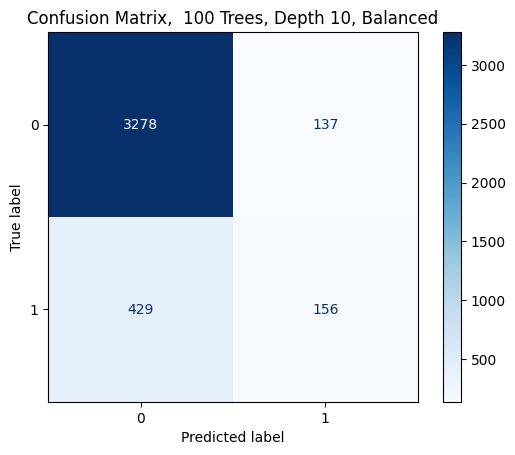

ROC AUC Score: 0.8480
Average Precision Score: 0.4703


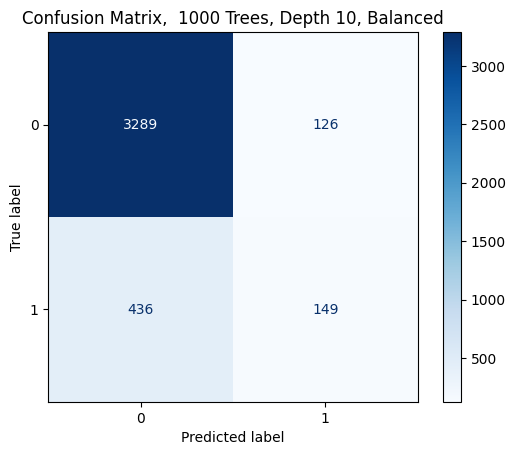

ROC AUC Score: 0.8507
Average Precision Score: 0.4818


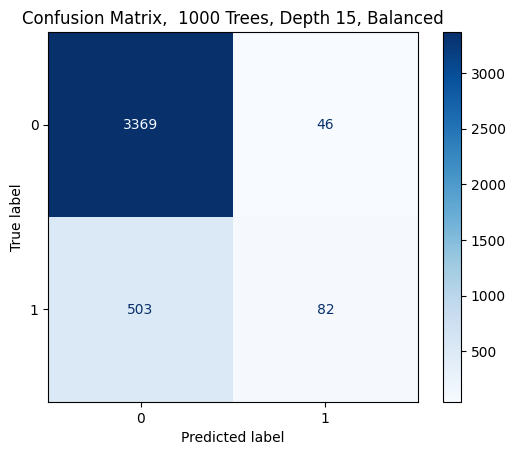

ROC AUC Score: 0.8493
Average Precision Score: 0.4778


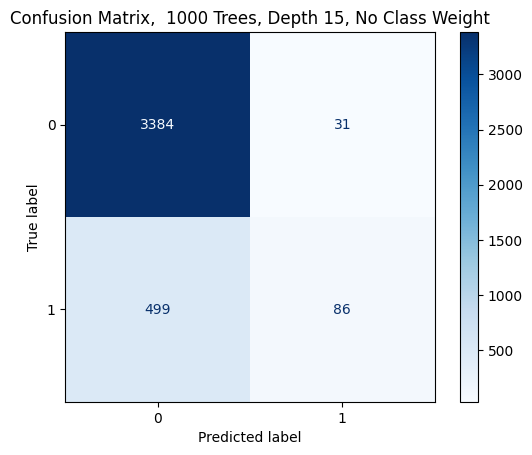

ROC AUC Score: 0.8304
Average Precision Score: 0.5102


(0.8304043248113526, 0.5102474515534927)

In [8]:

# --- Run a Few Models with Varying Parameters ---
feature_cols = [col for col in df_a.columns if col != 'RecordID_first']

# Model 1
rf1 = train_rf(df_a[feature_cols], outcomes_a['In-hospital_death'],
               n_estimators=100, max_depth=10, class_weight='balanced')
evaluate_model(rf1, df_c[feature_cols], outcomes_c['In-hospital_death'], title_info =' 100 Trees, Depth 10, Balanced')

# Model 2
rf2 = train_rf(df_a[feature_cols], outcomes_a['In-hospital_death'],
               n_estimators=1000, max_depth=10, class_weight='balanced')
evaluate_model(rf2, df_c[feature_cols], outcomes_c['In-hospital_death'], title_info =' 1000 Trees, Depth 10, Balanced')

# Model 3
rf3 = train_rf(df_a[feature_cols], outcomes_a['In-hospital_death'],
               n_estimators=1000, max_depth=15, class_weight='balanced')
evaluate_model(rf3, df_c[feature_cols], outcomes_c['In-hospital_death'], title_info =' 1000 Trees, Depth 15, Balanced')

# Model 4
rf4 = train_rf(df_a[feature_cols], outcomes_a['In-hospital_death'],
               n_estimators=1000, max_depth=15, class_weight=None)
evaluate_model(rf4, df_c[feature_cols], outcomes_c['In-hospital_death'], title_info =' 1000 Trees, Depth 15, No Class Weight')


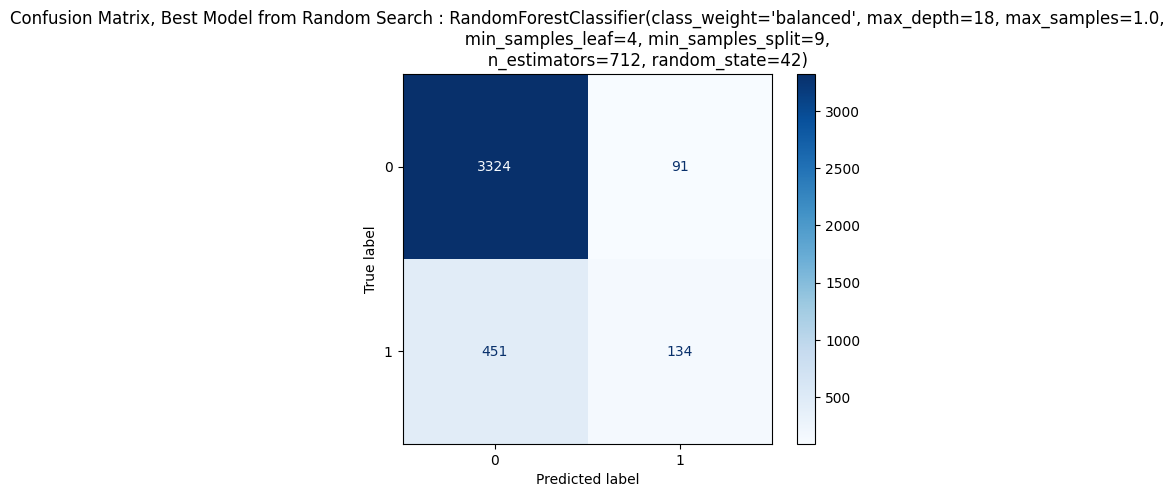

ROC AUC Score: 0.8510
Average Precision Score: 0.4956


(0.8510167561412071, 0.4956179301041763)

In [ ]:
# --- Evaluate Best Model ---
# best_rf = random_search.best_estimator_
best_rf = RandomForestClassifier(class_weight='balanced', max_depth=18, max_samples=1.0,
                       min_samples_leaf=4, min_samples_split=9,
                       n_estimators=712, random_state=42)
best_rf.fit(df_a[feature_cols], outcomes_a['In-hospital_death'])
evaluate_model(best_rf, df_c[feature_cols], outcomes_c['In-hospital_death'], title_info=f'Best Model from Random Search : {best_rf}')

#### Compute feature importance

Feature ranking:
1. feature 89 (0.024286) GCS__value__mean_change
2. feature 91 (0.023596) GCS__value__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"
3. feature 92 (0.023196) GCS__value__time_reversal_asymmetry_statistic__lag_1
4. feature 90 (0.022551) GCS__value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0
5. feature 93 (0.020904) GCS__value__last_location_of_maximum
6. feature 21 (0.017113) Urine__value__fft_coefficient__attr_"real"__coeff_0
7. feature 273 (0.015469) GCS_mean
8. feature 22 (0.014675) Urine__value__fft_coefficient__attr_"abs"__coeff_0
9. feature 203 (0.014219) Urine_mean
10. feature 69 (0.013829) BUN__value__fft_coefficient__attr_"abs"__coeff_0
11. feature 20 (0.013311) Urine__value__sum_values
12. feature 248 (0.011877) BUN_mean
13. feature 23 (0.011832) Urine__value__mean
14. feature 275 (0.010910) GCS_max
15. feature 66 (0.010321) BUN__value__mean_change
16. feature 251 (0.009950) BUN_min
17. feature 68 (0.009756) BUN__value__sum_values
1

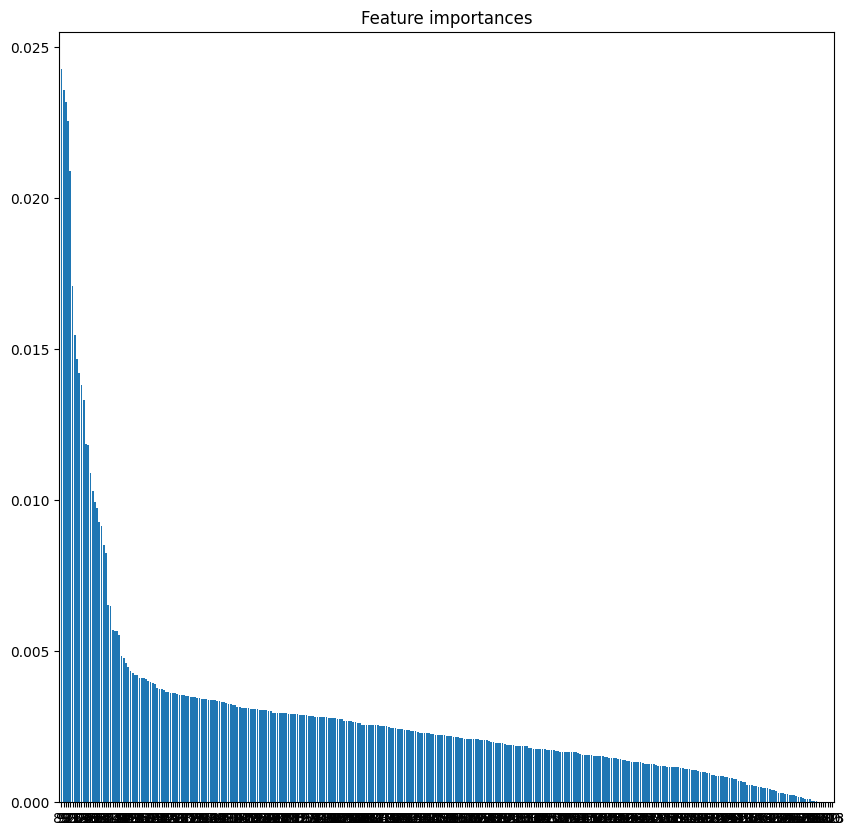

In [14]:
#  compute feature importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(feature_cols)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), df_a.columns[indices[f]])
# Plot the feature importances of the forest
plt.figure(figsize=(10, 10))
plt.title("Feature importances")
plt.bar(range(len(feature_cols)), importances[indices], align="center")
plt.xticks(range(len(feature_cols)), indices)
plt.xlim([-1, len(feature_cols)])
plt.show()

## Logistic  regression - Standard Scaler

In [15]:
# --- scaling Data ---
feature_cols = [col for col in df_a.columns if col != 'RecordID_first']

scaler = StandardScaler()
scaler.fit(df_a[feature_cols])

df_a_scaled = pd.DataFrame(scaler.transform(df_a[feature_cols]), columns=feature_cols)
# df_b_scaled = pd.DataFrame(scaler.transform(df_b[feature_cols]), columns=feature_cols)
df_c_scaled = pd.DataFrame(scaler.transform(df_c[feature_cols]), columns=feature_cols)


In [16]:
np.logspace(-3,3, 7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [17]:

# --- Grid Search for Best Regularization ---
# C = inverse of regularization strength, smaller values => stronger regularization

param_grid = {'C': np.logspace(-3, 3, 7)}
grid = GridSearchCV(LogisticRegression(max_iter=600, class_weight='balanced'),
                    param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(df_a_scaled, outcomes_a['In-hospital_death'])

best_log_reg = grid.best_estimator_
print("Best C:", grid.best_params_['C'])



Best C: 0.001


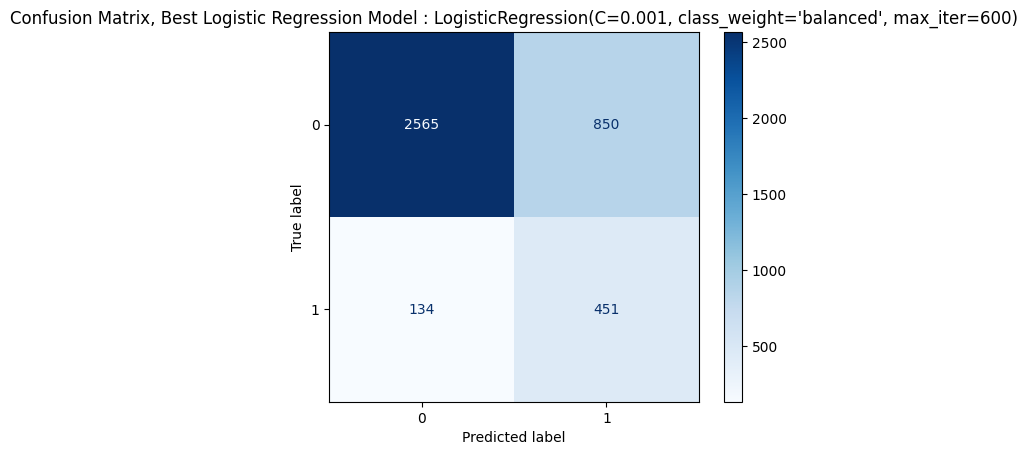

ROC AUC Score: 0.8494
Average Precision Score: 0.4787


(0.8493826882406676, 0.4786828643768975)

In [18]:
# --- Prediction on Test Set ---
evaluate_model(best_log_reg, df_c_scaled, outcomes_c['In-hospital_death'], title_info=f'Best Logistic Regression Model : {grid.best_estimator_}')

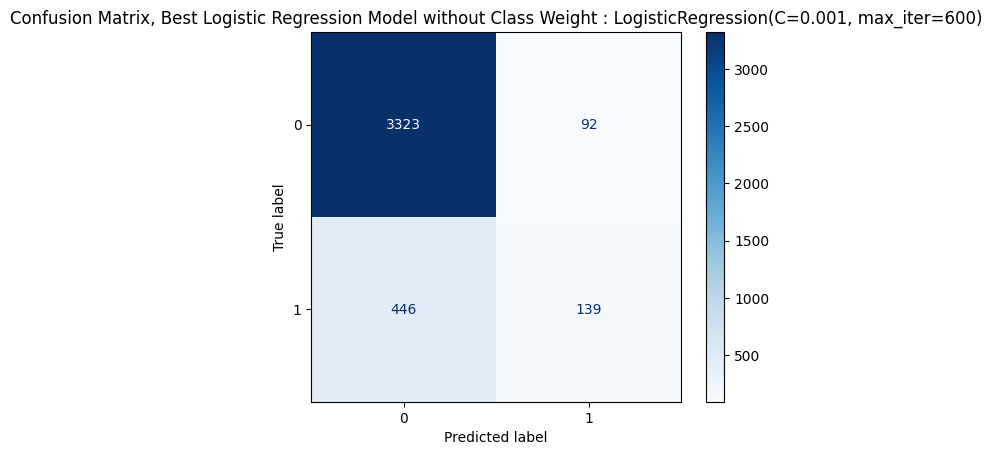

ROC AUC Score: 0.8476
Average Precision Score: 0.4744


(0.8476437536759647, 0.47441190155993335)

In [19]:
# model = best log reg but with no class weight
best_log_reg_no_weight = LogisticRegression(max_iter=600, C=grid.best_params_['C'])
best_log_reg_no_weight.fit(df_a_scaled, outcomes_a['In-hospital_death'])

evaluate_model(best_log_reg_no_weight, df_c_scaled, outcomes_c['In-hospital_death'], title_info=f'Best Logistic Regression Model without Class Weight : {best_log_reg_no_weight}')

## Logistic  regression - MinMax scaler


Best C: 0.1


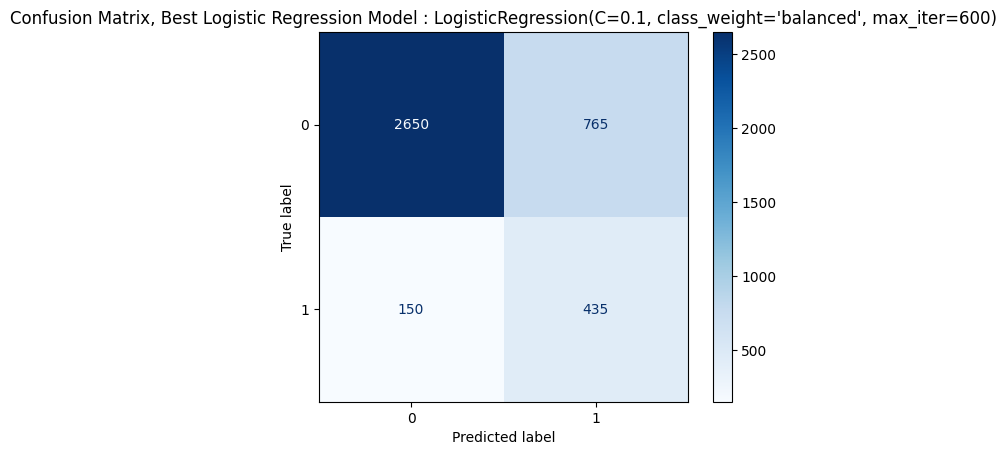

ROC AUC Score: 0.8485
Average Precision Score: 0.4844


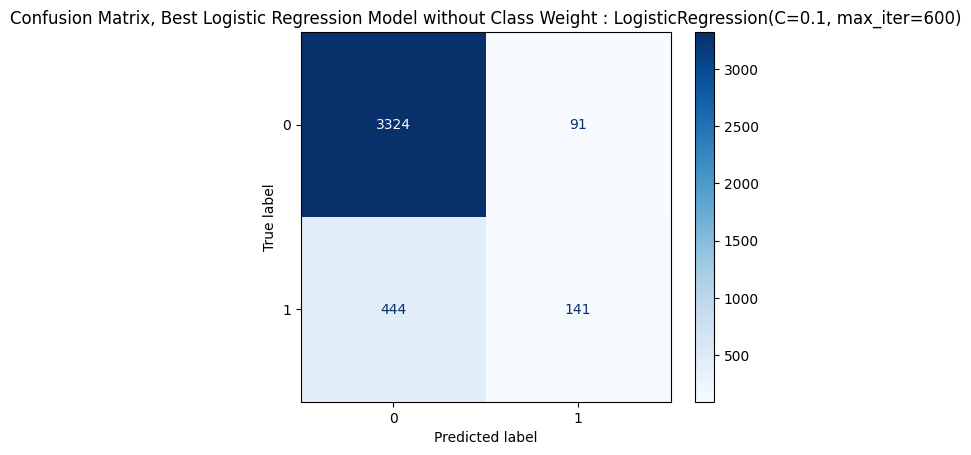

ROC AUC Score: 0.8509
Average Precision Score: 0.4880


(0.8508753488255685, 0.488018373751082)

In [20]:

# --- scaling Data ---
feature_cols = [col for col in df_a.columns if col != 'RecordID_first']

scaler = MinMaxScaler()
scaler.fit(df_a[feature_cols])

df_a_scaled = pd.DataFrame(scaler.transform(df_a[feature_cols]), columns=feature_cols)
# df_b_scaled = pd.DataFrame(scaler.transform(df_b[feature_cols]), columns=feature_cols)
df_c_scaled = pd.DataFrame(scaler.transform(df_c[feature_cols]), columns=feature_cols)

np.logspace(-3,3, 7)

# --- Grid Search for Best Regularization ---
# C = inverse of regularization strength, smaller values => stronger regularization

param_grid = {'C': np.logspace(-3, 3, 7)}
grid = GridSearchCV(LogisticRegression(max_iter=600, class_weight='balanced'),
                    param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(df_a_scaled, outcomes_a['In-hospital_death'])

best_log_reg = grid.best_estimator_
print("Best C:", grid.best_params_['C'])


# --- Prediction on Test Set ---
evaluate_model(best_log_reg, df_c_scaled, outcomes_c['In-hospital_death'], title_info=f'Best Logistic Regression Model : {grid.best_estimator_}')
# model = best log reg but with no class weight
best_log_reg_no_weight = LogisticRegression(max_iter=600, C=grid.best_params_['C'])
best_log_reg_no_weight.fit(df_a_scaled, outcomes_a['In-hospital_death'])

evaluate_model(best_log_reg_no_weight, df_c_scaled, outcomes_c['In-hospital_death'], title_info=f'Best Logistic Regression Model without Class Weight : {best_log_reg_no_weight}')
